In [1]:
%reload_ext autoreload
%autoreload 2
import tie.dbutils as db
import tie.utils as qa
import pandas as pd
from scipy.io import savemat, loadmat
import json
from tqdm import tqdm
import os
from collections import Counter
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import rc
import numpy as np
import matplotlib
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import DivergingNorm, TwoSlopeNorm, Normalize
from statsmodels.stats.multitest import fdrcorrection
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.patches as patches

In [2]:
rc('font', **{'family':'sans-serif',
              'sans-serif':['Helvetica']})
FONT_SIZE = 25
params = {'axes.labelsize': FONT_SIZE,
          'axes.titlesize': FONT_SIZE, 
          'legend.fontsize': FONT_SIZE, 
          'xtick.labelsize': FONT_SIZE, 
          'ytick.labelsize': FONT_SIZE}
matplotlib.rcParams.update(params)

ORDER = [0, 2, 3, 1] # Full, Social, Transition, Launcher
version = 'v6_IRLS'

In [3]:
study_id_1 = 'aef31aeb7b4d9dde43779738b42be454dc0ede19'  # -- Leiden Uni Age Study
study_id_2 = "aef333cc3597c660421091c3f4d8ecb4e809de19" # -- Leiden Uni 
study_id_3 = "aef34cc4d24c162f4f87becb74515e392560de19" # -- COOLS

In [4]:
raw_query = '''SELECT SDV."partId", SDV."devicePartId" as "devPartId", tde."deviceInfo", tde."id", "modified", "created"
from "StudyDetailsView" SDV
JOIN "TapDevice" tde on SDV."tapDeviceId" = tde."id"
where SDV."studyId"=? or SDV."studyId"=? or SDV."studyId"=?;'''
df = db.raw_query(raw_query, params=[study_id_1, study_id_2, study_id_3])
df['days'] = (df['modified'] - df['created'] ) / 1000 / 3600 / 24
df.head(2)

,partId,devPartId,deviceInfo,id,modified,created,days
0,138efc8063d3729040fb817663edae7c94b328eb,8sd8fe9d359d9d654c7fafb8efc55def56dc12ka,"{""androidVersion"":""9"",""deviceManufacturer"":""On...",0032fe57-d169-4a43-919d-bd415de40a8e,1592896678076,1587754338923,59.517814
1,138ee12eb779c05544cba2bfee03ecef1feb28eb,8sd8a4534d5635cb4936a9d848e019dfa68f12ka,"{""androidVersion"":""9"",""deviceManufacturer"":""mo...",00431dfe-0245-47fe-879e-e641daa55dc9,1568805227286,1565089811972,43.002492


In [5]:
info_age = pd.read_csv('../../only_info_figure_1.csv')
full_info = info_age.merge(df, on='partId').dropna().drop_duplicates("partId")
full_info.head(2)

,partId,age,n_taps,gender,devPartId,deviceInfo,id,modified,created,days
0,138ee6d165fa06954ba1bed56719415b12dd28eb,60,2645834,2,8sd8474d8c7c03ef46c5b3acf034d689257c12ka,"{""androidVersion"":""11"",""deviceManufacturer"":""s...",9feae480-d169-486e-b00d-02fcf4585d44,1625604609516,1593108388846,376.113665
2,138ee5b320ea6ee948d2a3bf2f8c55ffecd428eb,23,339201,2,8sd8762e35b65efa465fb90c7d2b7f5b5ad012ka,"{""androidVersion"":""10"",""deviceManufacturer"":""s...",f23fd700-1d72-4db0-a584-e7f979ad6d92,1620035028533,1593642422788,305.469974


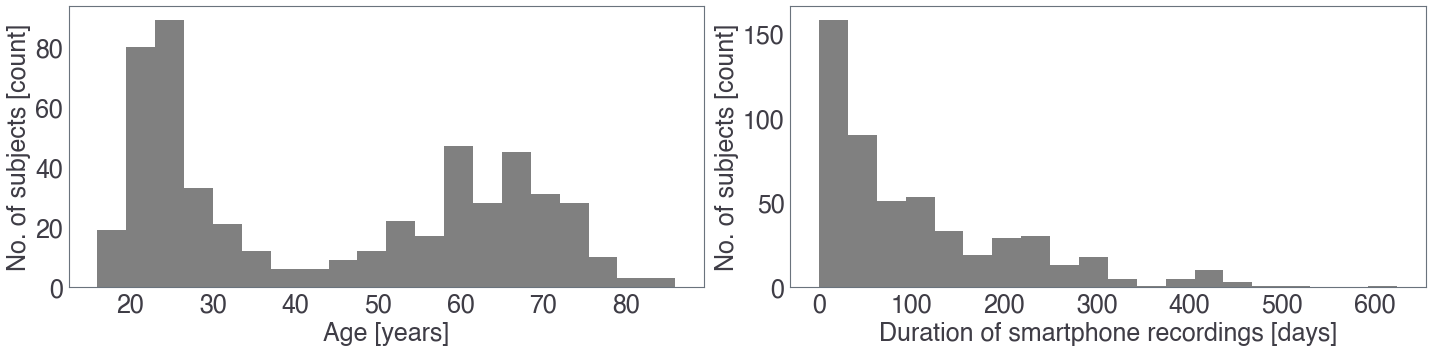

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(20, 5))

## AGE
full_info["age"].hist(bins=20, ax=ax[0], color='grey')

ax[0].set_xlabel("Age [years]")
ax[0].set_ylabel("No. of subjects [count]")
ax[0].grid(False)

## DAYS
full_info["days"].hist(bins=20, ax=ax[1], color='grey')

ax[1].set_xlabel("Duration of smartphone recordings [days]")
ax[1].set_ylabel("No. of subjects [count]")
ax[1].grid(False)

plt.tight_layout()
plt.savefig('figure_1_panel_a.pdf', transparent=True)

In [7]:
df_fig1pana = pd.DataFrame(columns={'type', 'N', 'min', 'max', '25th', '50th', '75th'})
df_fig1pana['type'] = ['female', 'age', 'days']
df_fig1pana['N'] = [len(full_info[full_info['gender'] == 2]), len(full_info), len(full_info)]
df_fig1pana['min'] = [np.nan, min(full_info['age']), min(full_info['days'])]
df_fig1pana['max'] = [np.nan, max(full_info['age']), max(full_info['days'])]
df_fig1pana['25th'] = [np.nan, np.percentile(full_info['age'], 25), np.percentile(full_info['days'], 25)]
df_fig1pana['50th'] = [np.nan, np.percentile(full_info['age'], 50), np.percentile(full_info['days'], 50)]
df_fig1pana['75th'] = [np.nan, np.percentile(full_info['age'], 75), np.percentile(full_info['days'], 75)]
df_fig1pana.to_csv('figure_1_panel_a.csv', index=False)
df_fig1pana

,type,max,25th,50th,min,75th,N
0,female,NaN,NaN,NaN,NaN,NaN,319
1,age,86.000000,23.000000,41.000000,16.0,63.000000,521
2,days,623.510652,20.441371,70.706858,0.0,162.985033,521


# Panel b

In [8]:
allJIDs = loadmat('ex_all_jids.mat')

In [9]:
fullJID = allJIDs['fullJID']
socialJID = allJIDs['socialJID']
launcherJID = allJIDs['launcherJID']
transitionJID = allJIDs['transitionJID']
print(fullJID.shape)

(50, 50)


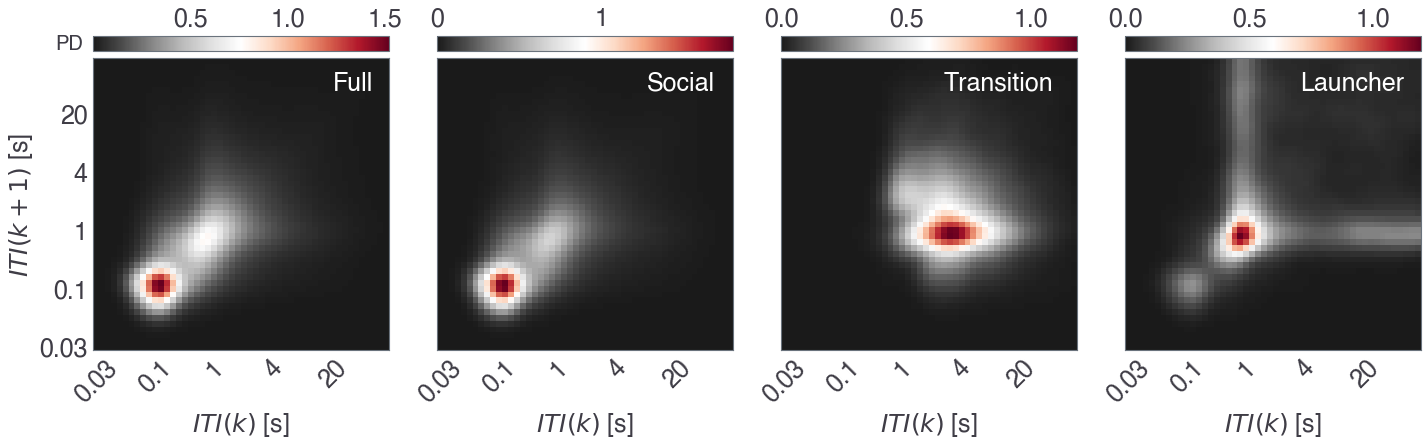

In [10]:
# This is over 166 days
fig, ax = plt.subplots(1, 4, figsize=(20, 6.3), sharey=True)

labels = ['0.03', '0.1', '1', '4', '20']
ticks = np.arange(50)[::10]

for i, (_JID, _title, x_bias) in enumerate(zip([fullJID, socialJID, transitionJID, launcherJID], 
                             ['Full', 'Social', 'Transition', 'Launcher'],
                             [40, 35, 27, 29])):
    im = ax[i].imshow(_JID.T, aspect='auto', cmap='RdGy_r')
    ax[i].text(x_bias, 44, f"{_title}", fontsize=25, color='white')
    ax[i].invert_yaxis()
    ax[i].set_xticks(ticks)
    ax[i].set_xticklabels(labels)
    ax[i].xaxis.set_tick_params(rotation=45)
    ax[i].set_yticks(ticks)
    ax[i].set_yticklabels(labels)
    ax[i].set_xlabel(r'$ITI(k)$ [s]')
    ax[i].grid(False)
    divider = make_axes_locatable(ax[i])
    cax = divider.new_vertical(size="5%", pad=.1, pack_start=False)
    fig.add_axes(cax)
    cb = fig.colorbar(im, cax=cax, orientation="horizontal")
    cb.ax.xaxis.set_ticks_position('top')
ax[0].set_ylabel(r'$ITI(k + 1)$ [s]');
ax[0].text(-7, 51, 'PD', size=20)
plt.tight_layout()
plt.savefig('figure_1_panel_b.pdf', transparent=True)

# Panel c

In [11]:
all_age_res = loadmat(f'../../all_age_gender_log_{version}.mat')['all_age_gender'][0]  # 4 structs for 4 JIDs

In [12]:
data_it = all_age_res[2].flat[0][0].flat[0]
A = data_it[3].squeeze().reshape(-1, 50, 50).T
print(A.shape)
B = data_it[4].squeeze()
print(B.shape)

(50, 50, 499)
(499, 3)


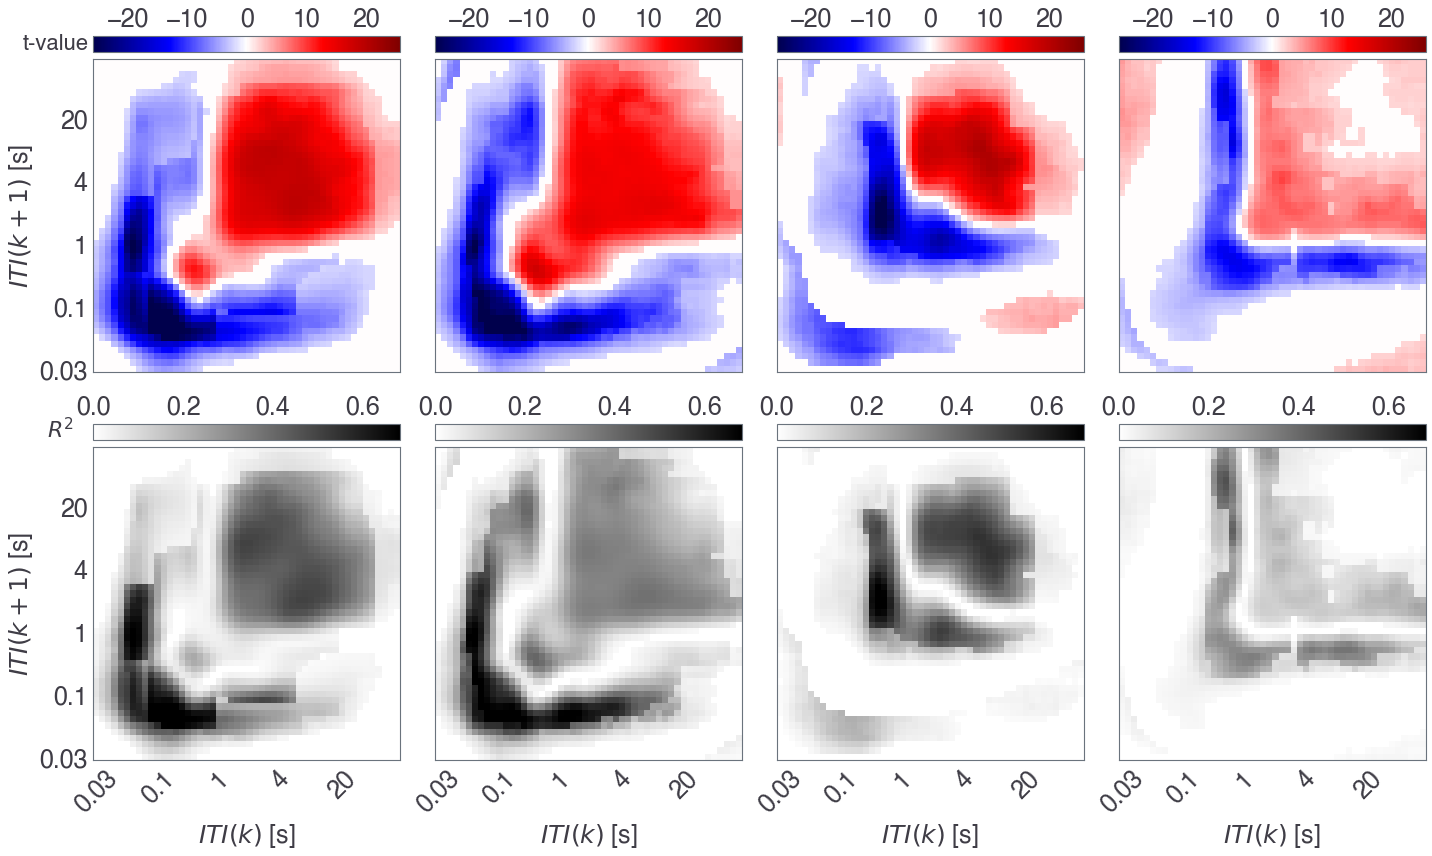

In [13]:
fig, ax = plt.subplots(2, 4, figsize=(20, 12), sharey=True, sharex=True)

labels = ['0.03', '0.1', '1', '4', '20']
ticks = np.arange(50)[::10]

vmax_f = -np.Inf
vmin_f = np.Inf
vmax_r = -np.Inf
vmin_r = np.Inf

for i in range(4):
    data_it = all_age_res[ORDER[i]].flat[0][0].flat[0]
    masks = [m[0].reshape(50, 50).T for m in data_it[0]]
    masks_uni = masks[:-1]
    mask_full = masks[-1]
    mdl = data_it[2]
    f_full = np.zeros(2500)
    r2_full = np.zeros(2500)
    p_full = np.zeros(2500)
    f_uni = np.zeros((2500, 2))
    p_uni = np.zeros((2500, 2))
    betas = np.zeros((2500, 3))

    # mdl is 2500 long
    for j, obj in enumerate(mdl):
        pixel = obj.flat[0][0][0]
        r2_full[j] = pixel[0][0][0]
        f_full[j] = pixel[1][0][0]
        p_full[j] = pixel[2][0][0]
        betas[j] = pixel[3].squeeze()
        continuous = pixel[7][0][0]
        f_uni[j] = continuous[0]
        p_uni[j] = continuous[1]


    k = betas[:, 0].reshape(50, 50).T  # T cause of matlab
    square_f = f_uni[:, 0].reshape(50, 50).T
    square_r2_full = r2_full.reshape(50, 50).T
    square_f[square_f < 0] = 0
    
    vmax_f = max(vmax_f, np.percentile(np.sqrt(square_f) * np.sign(k), 99))
    vmin_f = min(vmin_f, np.percentile(np.sqrt(square_f) * np.sign(k), 1))
    
    vmax_r = max(vmax_r, np.percentile(r2_full, 99))
    vmin_r = min(vmin_r, np.percentile(r2_full, 1))

tval_max = max([vmax_f, -vmin_f])

for i, _title in enumerate(['Full', 'Social', 'Transition', 'Launcher']):

    data_it = all_age_res[ORDER[i]].flat[0][0].flat[0]
    masks = [m[0].reshape(50, 50).T for m in data_it[0]]
    masks_uni = masks[:-1]
    mask_full = masks[-1]
    mdl = data_it[2]
    f_full = np.zeros(2500)
    r2_full = np.zeros(2500)
    p_full = np.zeros(2500)
    f_uni = np.zeros((2500, 2))
    p_uni = np.zeros((2500, 2))
    betas = np.zeros((2500, 3))

    # mdl is 2500 long
    for j, obj in enumerate(mdl):
        pixel = obj.flat[0][0][0]
        r2_full[j] = pixel[0][0][0]
        f_full[j] = pixel[1][0][0]
        p_full[j] = pixel[2][0][0]
        betas[j] = pixel[3].squeeze()
        continuous = pixel[7][0][0]
        f_uni[j] = continuous[0]
        p_uni[j] = continuous[1]
        

    k = betas[:, 0].reshape(50, 50).T  # T cause of matlab
    square_f = f_uni[:, 0].reshape(50, 50).T
    square_r2_full = r2_full.reshape(50, 50).T
    square_f[square_f < 0] = 0
    
    im = ax[0][i].imshow(np.sign(masks_uni[0]) * np.sqrt(square_f) * np.sign(k), aspect='auto', 
                         cmap='seismic', interpolation='none', norm=TwoSlopeNorm(0, vmin=-tval_max, vmax=tval_max))

    ax[0][i].invert_yaxis()
    ax[0][i].set_xticks(ticks)
    ax[0][i].set_xticklabels(labels)
    ax[0][i].xaxis.set_tick_params(rotation=45)
    ax[0][i].set_yticks(ticks)
    ax[0][i].set_yticklabels(labels)
#     ax[0][i].set_xlabel('ITI(k) [s]')
    ax[0][i].grid(False)
    divider = make_axes_locatable(ax[0][i])
    cax = divider.new_vertical(size="5%", pad=.1, pack_start=False)
    fig.add_axes(cax)
    cb = fig.colorbar(im, cax=cax, orientation="horizontal")
    cb.ax.xaxis.set_ticks_position('top')
    _t = cb.get_ticks()
#     cb.set_ticks([0] + list(np.arange(min(_t), max(_t), 2)))
    

    im = ax[1][i].imshow(np.sign(mask_full) * square_r2_full, aspect='auto', cmap='binary', 
                            interpolation='none', norm=Normalize(0, vmax=vmax_r * 0.99))
    ax[1][i].invert_yaxis()
    ax[1][i].set_xticks(ticks)
    ax[1][i].set_xticklabels(labels)
    ax[1][i].xaxis.set_tick_params(rotation=45)
    ax[1][i].set_yticks(ticks)
    ax[1][i].set_yticklabels(labels)
    ax[1][i].set_xlabel(r'$ITI(k)$ [s]')
    ax[1][i].grid(False)
    divider = make_axes_locatable(ax[1][i])
    cax = divider.new_vertical(size="5%", pad=.1, pack_start=False)
    fig.add_axes(cax)
    cb = fig.colorbar(im, cax=cax, orientation="horizontal")
    cb.ax.xaxis.set_ticks_position('top')
    _t = cb.get_ticks()
#     _t = cb.set_ticks(np.arange(0.0, max(_t) + .1, .2))
    
ax[0][0].set_ylabel(r'$ITI(k + 1)$ [s]');
ax[1][0].set_ylabel(r'$ITI(k + 1)$ [s]');
ax[0][0].text(-12, 51, 't-value', size=22)    
ax[1][0].text(-8, 51, r'$R^2$', size=22)    
plt.tight_layout()
plt.savefig('figure_1_panel_c.pdf', transparent=True)

#### Supplementary 2

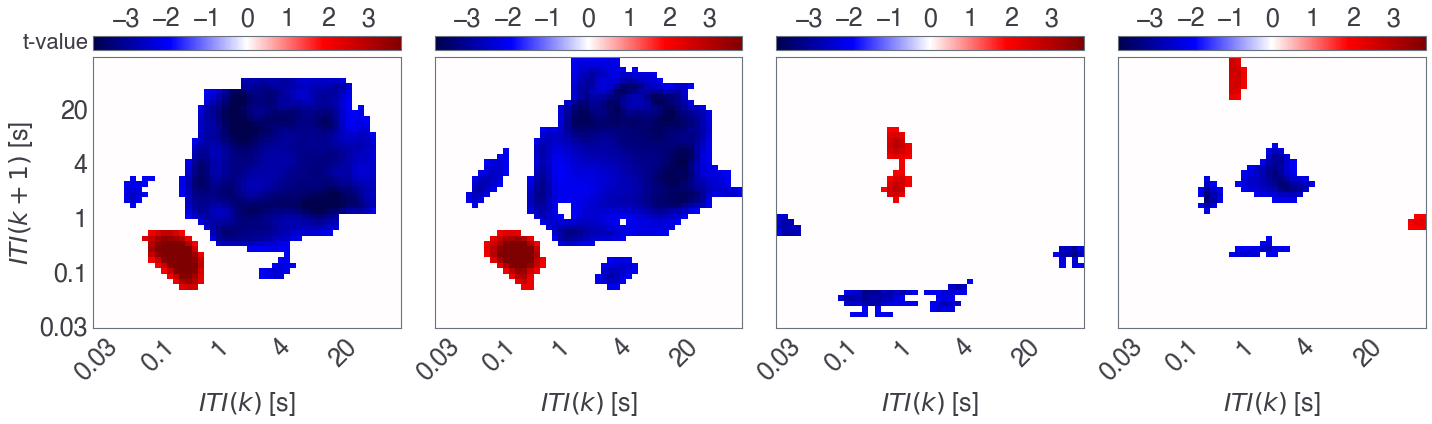

In [14]:
fig, ax = plt.subplots(1, 4, figsize=(20, 6), sharey=True, sharex=True)
    
labels = ['0.03', '0.1', '1', '4', '20']
ticks = np.arange(50)[::10]

vmax_f = -np.Inf
vmin_f = np.Inf
vmax_r = -np.Inf
vmin_r = np.Inf

for i in range(4):
    data_it = all_age_res[ORDER[i]].flat[0][0].flat[0]
    masks = [m[0].reshape(50, 50).T for m in data_it[0]]
    masks_uni = masks[:-1]
    mask_full = masks[-1]
    mdl = data_it[2]
    f_full = np.zeros(2500)
    r2_full = np.zeros(2500)
    p_full = np.zeros(2500)
    f_uni = np.zeros((2500, 2))
    p_uni = np.zeros((2500, 2))
    betas = np.zeros((2500, 3))

    # mdl is 2500 long
    for j, obj in enumerate(mdl):
        pixel = obj.flat[0][0][0]
        r2_full[j] = pixel[0][0][0]
        f_full[j] = pixel[1][0][0]
        p_full[j] = pixel[2][0][0]
        betas[j] = pixel[3].squeeze()
        continuous = pixel[7][0][0]
        f_uni[j] = continuous[0]
        p_uni[j] = continuous[1]
        

    k = betas[:, 1].reshape(50, 50).T  # T cause of matlab
    square_f = f_uni[:, 1].reshape(50, 50).T
    square_r2_full = r2_full.reshape(50, 50).T
    square_f[square_f < 0] = 0
    
    vmax_f = max(vmax_f, np.percentile(np.sqrt(square_f) * np.sign(k), 99))
    vmin_f = min(vmin_f, np.percentile(np.sqrt(square_f) * np.sign(k), 1))
    
    vmax_r = max(vmax_r, np.max(r2_full))
    vmin_r = min(vmin_r, np.min(r2_full))

tval_max = max([vmax_f, -vmin_f])

for i, _title in enumerate(['Full', 'Social', 'Transition', 'Launcher']):

    data_it = all_age_res[ORDER[i]].flat[0][0].flat[0]
    masks = [m[0].reshape(50, 50).T for m in data_it[0]]
    masks_uni = masks[:-1]
    mask_full = masks[-1]
    mdl = data_it[2]
    f_full = np.zeros(2500)
    r2_full = np.zeros(2500)
    p_full = np.zeros(2500)
    f_uni = np.zeros((2500, 2))
    p_uni = np.zeros((2500, 2))
    betas = np.zeros((2500, 3))

    # mdl is 2500 long
    for j, obj in enumerate(mdl):
        pixel = obj.flat[0][0][0]
        r2_full[j] = pixel[0][0][0]
        f_full[j] = pixel[1][0][0]
        p_full[j] = pixel[2][0][0]
        betas[j] = pixel[3].squeeze()
        continuous = pixel[7][0][0]
        f_uni[j] = continuous[0]
        p_uni[j] = continuous[1]
        
    k = betas[:, 1].reshape(50, 50).T  # T cause of matlab
    square_f = f_uni[:, 1].reshape(50, 50).T
    square_r2_full = r2_full.reshape(50, 50).T
    square_f[square_f < 0] = 0
    
    im = ax[i].imshow(np.sign(masks_uni[1]) * np.sqrt(square_f) * np.sign(k), aspect='auto', 
                         cmap='seismic', interpolation='none', norm=TwoSlopeNorm(0, vmin=-tval_max, vmax=tval_max))

    ax[i].invert_yaxis()
    ax[i].set_xticks(ticks)
    ax[i].set_xticklabels(labels)
    ax[i].xaxis.set_tick_params(rotation=45)
    ax[i].set_yticks(ticks)
    ax[i].set_yticklabels(labels)
    ax[i].set_xlabel(r'$ITI(k)$ [s]')
    ax[i].grid(False)
    divider = make_axes_locatable(ax[i])
    cax = divider.new_vertical(size="5%", pad=.1, pack_start=False)
    fig.add_axes(cax)
    cb = fig.colorbar(im, cax=cax, orientation="horizontal")
    cb.ax.xaxis.set_ticks_position('top')
    _t = cb.get_ticks()

ax[0].set_ylabel(r'$ITI(k + 1)$ [s]');
ax[0].text(-12, 51, 't-value', size=22)    
plt.tight_layout()
plt.savefig('figure_1_supplementary_ii.pdf', transparent=True)

# Panel d

<ipython-input-15-03a69cb02092>:66: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


,N,f-value,R2,JID,beta,p-value
0,515,505.552056,0.771566,Full,-0.037693,0.0
1,499,468.353715,0.765157,Social,-0.048593,0.0
2,502,374.001424,0.708894,Transition,-0.024105,0.0
3,495,121.583359,0.462012,Launcher,-0.015597,0.0


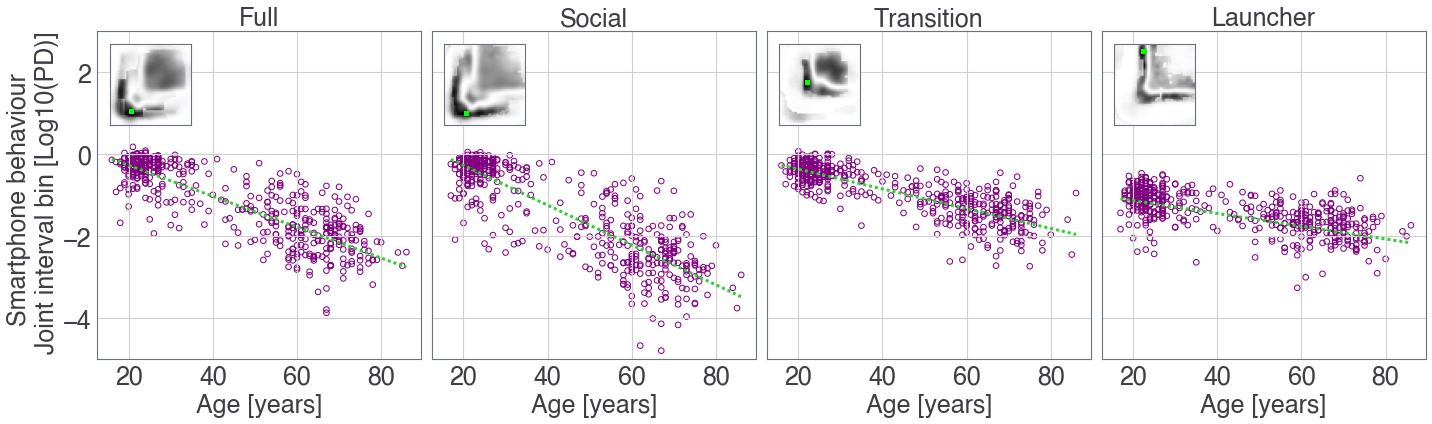

In [15]:
df_fig1pand = pd.DataFrame(columns={'JID', 'N', 'R2', 'p-value', 'f-value', 'beta'})
fig, ax = plt.subplots(1, 4, figsize=(20, 6), sharey=True, sharex=True)

labels = ['0.03', '0.1', '1', '4', '20']
ticks = np.arange(50)[::10]

for i, _title in enumerate(['Full', 'Social', 'Transition', 'Launcher']):
    
    data_it = all_age_res[ORDER[i]].flat[0][0].flat[0]
    masks = [m[0].reshape(50, 50).T for m in data_it[0]]
    masks_uni = masks[:-1]
    mask_full = masks[-1]
    mdl = data_it[2]
    A = data_it[3].squeeze()
    B = data_it[4].squeeze()
    f_full = np.zeros(2500)
    r2_full = np.zeros(2500)
    p_full = np.zeros(2500)
    f_uni = np.zeros((2500, 2))
    p_uni = np.zeros((2500, 2))
    betas = np.zeros((2500, 3))

    # mdl is 2500 long
    for j, obj in enumerate(mdl):
        pixel = obj.flat[0][0][0]
        r2_full[j] = pixel[0][0][0]
        f_full[j] = pixel[1][0][0]
        p_full[j] = pixel[2][0][0]
        betas[j] = pixel[3].squeeze()
        continuous = pixel[7][0][0]
        f_uni[j] = continuous[0]
        p_uni[j] = continuous[1]
        
    
    idx = np.argmax(r2_full)
    _y = A[:, idx]
    _x = B[:, 0]
    _k = betas[idx]
    
    ax[i].scatter(_x, _y, facecolors='none', edgecolors='purple', label='Subjects', linewidth=1)
    ax[i].plot([_x.min(), _x.max()], np.array([_x.min(), _x.max()]) * _k[0] + _k[2], 'limegreen', dashes=[1, 1], linewidth=3, label="Linear Fit")
    
    ax[i].set_ylim([-5, 3])
    ax[i].set_title(_title)
    ax[i].set_xlabel("Age [years]")

    df_fig1pand = df_fig1pand.append({'JID': _title, 'N': len(_x), 
                                      'R2': r2_full[idx], 'p-value': p_full[idx], 
                                      'f-value': f_full[idx], 'beta':_k[0]}, ignore_index=True)
    
    inset_ax = inset_axes(ax[i],
                          height="25%", # set height
                          width="25%", # and width
                          loc='upper left') # center, you can check the different codes in plt.legend?
    inset_ax.imshow(r2_full.reshape(50, 50).T, cmap='binary')
    inset_ax.xaxis.set_visible(False)
    inset_ax.yaxis.set_visible(False)
    inset_ax.grid(False)
    inset_ax.invert_yaxis()
    x1 = idx % 50
    y1 = idx // 50;
    rect1 = matplotlib.patches.Rectangle((y1, x1), 2, 2, linewidth=2, edgecolor='lime', facecolor='lime')
    inset_ax.add_patch(rect1)
    
ax[0].set_ylabel("Smartphone behaviour \n Joint interval bin [Log10(PD)]");
plt.tight_layout()
plt.savefig("figure_1_panel_d.pdf", transparent=True)
df_fig1pand.to_csv('figure_1_panel_d.csv', index=False)
df_fig1pand

# Supplementary

## S1

In [16]:
## Need to first run the MATLAB script `entropy_fig1supi.m`
all_age_entropy = loadmat('../../adjusted_entropy_response.mat')['all_adjusted'][0]

Full : R2 = 0.02 | p-val = 4.86e-01
Social : R2 = 0.03 | p-val = 5.05e-02
Transition : R2 = 0.09 | p-val = 4.11e-07
Launcher : R2 = 0.28 | p-val = 1.04e-21


,N,f-value,R2,JID,beta,p-value
0,420,NaN,0.016558,Full,NaN,4.857953e-01
1,411,NaN,0.030806,Social,NaN,5.048720e-02
2,412,NaN,0.090460,Transition,NaN,4.111859e-07
3,409,NaN,0.281469,Launcher,NaN,1.040818e-21


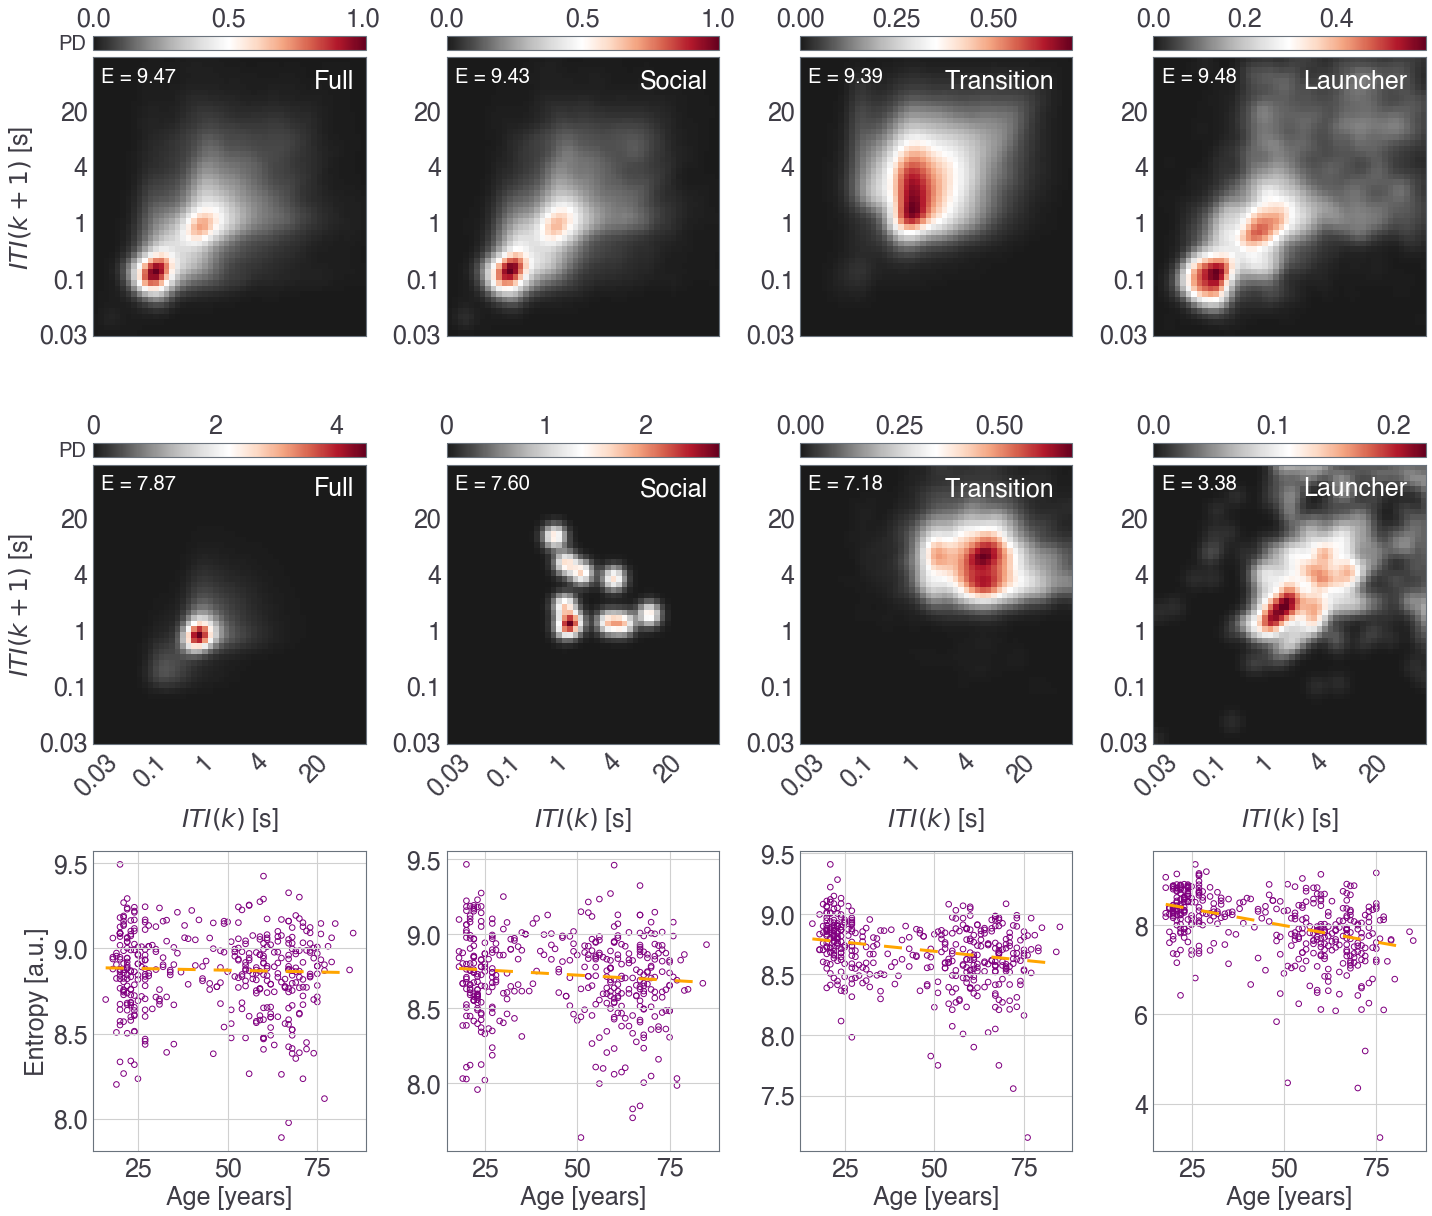

In [17]:
df_fig1suppi = pd.DataFrame(columns={'JID', 'N', 'R2', 'p-value', 'f-value', 'beta'})
fig, ax = plt.subplots(3, 4, figsize=(20, 17))

labels = ['0.03', '0.1', '1', '4', '20']
ticks = np.arange(50)[::10]

vmin = np.Inf
vmax = -np.Inf

for i in range(4):
    age_entropy = all_age_entropy[i].flat[0]
    adjusted_fit = age_entropy[0]
    adjusted_data = age_entropy[1]
    entropy = age_entropy[2]
    age = age_entropy[3]
    gender = age_entropy[4]
    allJIDs = age_entropy[5]
    r2 = age_entropy[7][0][0]
    pval = age_entropy[8][0][0]
    
    idx_max = np.argmax(entropy)
    idx_min = np.argmin(entropy)
    
    _jid_max = 10 ** allJIDs[idx_max].reshape(50, 50).T
    _jid_min = 10 ** allJIDs[idx_min].reshape(50, 50).T
    
    vmin = min(vmin, np.min(_jid_max))
    vmin = min(vmin, np.min(_jid_min))
    
    vmax = max(vmax, np.max(_jid_max))
    vmax = max(vmax, np.max(_jid_min))

for i, (_title, _ylim, x_bias) in enumerate(zip(['Full', 'Social', 'Transition', 'Launcher'], [7.85, 7.6, 7.1, 3.2], [40, 35, 26, 27])):
    
    age_entropy = all_age_entropy[ORDER[i]].flat[0]
    adjusted_fit = age_entropy[0]
    adjusted_data = age_entropy[1]
    entropy = age_entropy[2]
    age = age_entropy[3]
    gender = age_entropy[4]
    allJIDs = age_entropy[5]
    r2 = age_entropy[7][0][0]
    pval = age_entropy[8][0][0]
    
    idx_max = np.argmax(entropy)
    idx_min = np.argmin(entropy)
    
    _jid_max = 10 ** allJIDs[idx_max].reshape(50, 50).T
    _jid_min = 10 ** allJIDs[idx_min].reshape(50, 50).T
    
    im = ax[0][i].imshow(_jid_max, aspect='auto', cmap='RdGy_r')
#     ax[0][i].set_title(f"{entropy[idx_max][0]:.2f}")
    ax[0][i].invert_yaxis()
    ax[0][i].set_xticks([])
    ax[0][i].set_xticklabels([])
    ax[0][i].xaxis.set_tick_params(rotation=45)
    ax[0][i].set_yticks(ticks)
    ax[0][i].set_yticklabels(labels)
#     ax[0][i].set_xlabel('ITI(k) [s]')
    ax[0][i].grid(False)
    divider = make_axes_locatable(ax[0][i])
    cax = divider.new_vertical(size="5%", pad=.1, pack_start=False)
    fig.add_axes(cax)
    cb = fig.colorbar(im, cax=cax, orientation="horizontal")
    cb.ax.xaxis.set_ticks_position('top')
    _t = cb.get_ticks()
    ax[0][i].text(x_bias, 44, f"{_title}", fontsize=25, color='white')
#     cb.set_ticks([0] + list(np.arange(min(_t), max(_t), 2)))
    
    im = ax[1][i].imshow(_jid_min, aspect='auto', cmap='RdGy_r')
#     ax[1][i].set_title(f"{entropy[idx_min][0]:.2f}")
    ax[1][i].invert_yaxis()
    ax[1][i].set_xticks(ticks)
    ax[1][i].set_xticklabels(labels)
    ax[1][i].xaxis.set_tick_params(rotation=45)
    ax[1][i].set_yticks(ticks)
    ax[1][i].set_yticklabels(labels)
    ax[1][i].set_xlabel(r'$ITI(k)$ [s]')
    ax[1][i].grid(False)
    divider = make_axes_locatable(ax[1][i])
    cax = divider.new_vertical(size="5%", pad=.1, pack_start=False)
    fig.add_axes(cax)
    cb = fig.colorbar(im, cax=cax, orientation="horizontal")
    cb.ax.xaxis.set_ticks_position('top')
    _t = cb.get_ticks()
    ax[1][i].text(x_bias, 44, f"{_title}", fontsize=25, color='white')
    
    ax[0][i].text(1, 45, f"E = {entropy[idx_max][0]:.2f}", fontsize=20, color='white')
    ax[1][i].text(1, 45, f"E = {entropy[idx_min][0]:.2f}", fontsize=20, color='white')
#     cb.set_ticks([0] + list(np.arange(min(_t), max(_t), 2)))
    
    
    ax[2][i].scatter(adjusted_data[0], adjusted_data[1], facecolors='none', edgecolors='purple', label='Subjects', linewidth=1)
    ax[2][i].plot(adjusted_fit[0], adjusted_fit[1], 'orange', dashes=[6, 6], linewidth=3, label="Linear Fit")
    ax[2][i].set_xlabel('Age [years]')
    print(f"{_title} : R2 = {r2:.2f} | p-val = {pval:.2e}")
    df_fig1suppi = df_fig1suppi.append({'JID': _title, 'N': len(adjusted_data[0]), 
                                      'R2': r2, 'p-value': pval, 
                                      'f-value': np.nan, 'beta': np.nan}, ignore_index=True)
#     ax[2][i].text(15, _ylim , f"R2 = {r2:.2f} \np-val = {pval:.2e}", fontsize=20)
    
ax[0][0].set_ylabel(r'$ITI(k + 1)$ [s]')
ax[1][0].set_ylabel(r'$ITI(k + 1)$ [s]')
ax[0][0].text(-7, 51, 'PD', size=20)
ax[1][0].text(-7, 51, 'PD', size=20)
ax[2][0].set_ylabel("Entropy [a.u.]")
plt.tight_layout()
plt.savefig('figure_1_supplementary_i.pdf', transparent=True)
df_fig1suppi.to_csv('figure_1_supplementary_i.csv', index=False)
df_fig1suppi

# S3

8


,N,f-value,R2,beta,p-value
0,352.0,NaN,0.257007,NaN,1.124615e-22


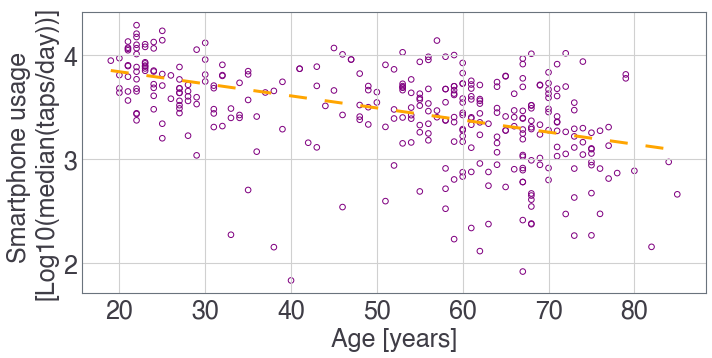

In [20]:
df_fig1suppiii = pd.DataFrame(columns={'N', 'R2', 'p-value', 'f-value', 'beta'})
adjusted = loadmat('../../suppl_iii.mat')['adjusted'].flat[0]
print(len(adjusted))

adjusted_fit = adjusted[0]
adjusted_data = adjusted[1]
usage = adjusted[2]
age = adjusted[3]
gender = adjusted[4]
r2 = adjusted[6][0][0]
pval = adjusted[7][0][0]

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.scatter(adjusted_data[0], adjusted_data[1], facecolors='none', edgecolors='purple', label='Subjects', linewidth=1)
ax.plot(adjusted_fit[0], adjusted_fit[1], 'orange', dashes=[6, 6], linewidth=3, label="Linear Fit")
ax.set_xlabel('Age [years]')

df_fig1suppiii = df_fig1suppiii.append({'N': len(adjusted_data[0]), 
                                      'R2': r2, 'p-value': pval, 
                                      'f-value': np.nan, 'beta': np.nan}, ignore_index=True)

# ax.text(17, 1.8, f"R2 = {r2:.2f} \np-val = {pval:.2e}", fontsize=20)
ax.set_ylabel("Smartphone usage \n[Log10(median(taps/day))]")
plt.tight_layout()
plt.savefig('figure_1_supplementary_iii.pdf')
df_fig1suppiii.to_csv('figure_1_supplementary_iii.csv', index=False)
df_fig1suppiii

# S4

In [18]:
pix_usage = loadmat(f'../../all_age_gender_usage_pixel_{version}.mat')['all_age_gender_usage_pixel'][0]
print(len(pix_usage))

FileNotFoundError: [Errno 2] No such file or directory: '../../all_age_gender_usage_pixel_v6_IRLS.mat'

In [ ]:
fig, ax = plt.subplots(4, 4, figsize=(20, 21), sharey=True, sharex=True)

labels = ['0.03', '0.1', '1', '4', '20']
ticks = np.arange(50)[::10]

vmax_f = -np.Inf
vmin_f = np.Inf
vmax_r = -np.Inf
vmin_r = np.Inf

for i in range(4):
    data_it = pix_usage[ORDER[i]].flat[0][0].flat[0]
    masks = [m[0].reshape(50, 50).T for m in data_it[0]]
    masks_uni = masks[:-1]
    mask_full = masks[-1]
    mdl = data_it[2]
    f_full = np.zeros(2500)
    r2_full = np.zeros(2500)
    p_full = np.zeros(2500)
    f_uni = np.zeros((2500, 3))
    p_uni = np.zeros((2500, 3))
    betas = np.zeros((2500, 4))

    # mdl is 2500 long
    for j, obj in enumerate(mdl):
        pixel = obj.flat[0][0][0]
        r2_full[j] = pixel[0][0][0]
        f_full[j] = pixel[1][0][0]
        p_full[j] = pixel[2][0][0]
        betas[j] = pixel[3].squeeze()
        continuous = pixel[7][0][0]
        f_uni[j] = continuous[0]
        p_uni[j] = continuous[1]

    for jj in range(3):

        k = betas[:, jj].reshape(50, 50).T  # T cause of matlab
        square_f = f_uni[:, jj].reshape(50, 50).T
        square_r2_full = r2_full.reshape(50, 50).T
        square_f[square_f < 0] = 0

        vmax_f = max(vmax_f, np.percentile(np.sqrt(square_f) * np.sign(k), 99))
        vmin_f = min(vmin_f, np.percentile(np.sqrt(square_f) * np.sign(k), 1))

        vmax_r = max(vmax_r, np.percentile(r2_full, 99))
        vmin_r = min(vmin_r, np.percentile(r2_full, 1))

tval_max = max([vmax_f, -vmin_f])

for i, _title in enumerate(['Full', 'Social', 'Transition', 'Launcher']):

    data_it = pix_usage[ORDER[i]].flat[0][0].flat[0]
    masks = [m[0].reshape(50, 50).T for m in data_it[0]]
    masks_uni = masks[:-1]
    mask_full = masks[-1]
    mdl = data_it[2]
    f_full = np.zeros(2500)
    r2_full = np.zeros(2500)
    p_full = np.zeros(2500)
    f_uni = np.zeros((2500, 3))
    p_uni = np.zeros((2500, 3))
    betas = np.zeros((2500, 4))

    # mdl is 2500 long
    for j, obj in enumerate(mdl):
        pixel = obj.flat[0][0][0]
        r2_full[j] = pixel[0][0][0]
        f_full[j] = pixel[1][0][0]
        p_full[j] = pixel[2][0][0]
        betas[j] = pixel[3].squeeze()
        continuous = pixel[7][0][0]
        f_uni[j] = continuous[0]
        p_uni[j] = continuous[1]
        
    for jj in range(3):
        k = betas[:, jj].reshape(50, 50).T  # T cause of matlab
        square_f = f_uni[:, jj].reshape(50, 50).T
        square_r2_full = r2_full.reshape(50, 50).T
        square_f[square_f < 0] = 0

        im = ax[jj][i].imshow(np.sign(masks_uni[jj]) * np.sqrt(square_f) * np.sign(k), aspect='auto', 
                             cmap='seismic', interpolation='none', norm=TwoSlopeNorm(0, vmin=-tval_max, vmax=tval_max))

        ax[jj][i].invert_yaxis()
        ax[jj][i].set_xticks(ticks)
        ax[jj][i].set_xticklabels(labels)
        ax[jj][i].xaxis.set_tick_params(rotation=45)
        ax[jj][i].set_yticks(ticks)
        ax[jj][i].set_yticklabels(labels)
    #     ax[0][i].set_xlabel('ITI(k) [s]')
        ax[jj][i].grid(False)
        divider = make_axes_locatable(ax[jj][i])
        cax = divider.new_vertical(size="5%", pad=.1, pack_start=False)
        fig.add_axes(cax)
        cb = fig.colorbar(im, cax=cax, orientation="horizontal")
        cb.ax.xaxis.set_ticks_position('top')
        _t = cb.get_ticks()
#     cb.set_ticks([0] + list(np.arange(min(_t), max(_t), 2)))
    

    im = ax[3][i].imshow(np.sign(mask_full) * square_r2_full, aspect='auto', cmap='binary', 
                            interpolation='none', norm=Normalize(0, vmax=vmax_r * 0.99))
    ax[3][i].invert_yaxis()
    ax[3][i].set_xticks(ticks)
    ax[3][i].set_xticklabels(labels)
    ax[3][i].xaxis.set_tick_params(rotation=45)
    ax[3][i].set_yticks(ticks)
    ax[3][i].set_yticklabels(labels)
    ax[3][i].set_xlabel(r'$ITI(k)$ [s]')
    ax[3][i].grid(False)
    divider = make_axes_locatable(ax[3][i])
    cax = divider.new_vertical(size="5%", pad=.1, pack_start=False)
    fig.add_axes(cax)
    cb = fig.colorbar(im, cax=cax, orientation="horizontal")
    cb.ax.xaxis.set_ticks_position('top')
    _t = cb.get_ticks()
#     _t = cb.set_ticks(np.arange(0.0, max(_t) + .1, .2))
    
ax[0][0].set_ylabel(r'$ITI(k + 1)$ [s]');
ax[1][0].set_ylabel(r'$ITI(k + 1)$ [s]');
ax[2][0].set_ylabel(r'$ITI(k + 1)$ [s]');
ax[3][0].set_ylabel(r'$ITI(k + 1)$ [s]');

ax[0][0].text(-12, 51, 't-value', size=22)   
ax[1][0].text(-12, 51, 't-value', size=22)   
ax[2][0].text(-12, 51, 't-value', size=22)   
ax[3][0].text(-8, 51, r'$R^2$', size=22)    

plt.tight_layout()
plt.savefig('figure_1_supplementary_iv.pdf', transparent=True)